In [6]:
import sys
sys.path.append("../")
from os.path import join
from IPython.display import display

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=False)

import scipy
import faiss
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from lolip.extra_ood_utils import get_ood_data_paths
from lolip.models.torch_utils import archs
from lolip.variables import auto_var

pd.set_option('display.max_rows', 200)


fontsize=15

# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

def get_preds(model, dset, batch_size=64, device="cuda"):
    model.eval().to(device)
    if isinstance(dset, np.ndarray):
        dset = torch.utils.data.TensorDataset(
            torch.from_numpy(dset.transpose(0, 3, 1, 2)).float(),
            torch.ones(len(dset))
        )

    loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=24)
    
    ret = []
    for (x, _) in tqdm(loader):
        with torch.no_grad():
            output = F.softmax(model(x.to(device)), dim=1)
        ret.append(output.cpu().numpy())
    del loader
    return np.concatenate(ret, axis=0)

def get_results(preds, nnidxs, dists):
    data = {}
    
    for key in preds.keys():
        ds_name, model_name = key
        trnX, trny, tstX, tsty, _ = auto_var.get_var_with_argument("dataset", ds_name)
        
        data[(ds_name, model_name, 'tst acc')] = [(preds[key]['tst'].argmax(1) == tsty).mean()]
        for i, ood_name in enumerate(ood_names):
            nnacc = (np.tile(tsty, 5) == trny[nnidxs[key][ood_name]])
            res = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
            if preds[key][ood_name].argmax(1).shape[0] != (len(tsty) * 5):
                import ipdb; ipdb.set_trace()
            oodacc = (preds[key][ood_name].argmax(1) == np.tile(tsty, 5))
            
            counts = 10000
            for i in range(5):
                data[(ds_name, model_name, f"nnacc_{ood_name}_{i+1}")] = nnacc[i * counts: (i+1) * counts].mean()
                data[(ds_name, model_name, f"overlap_{ood_name}_{i+1}")] = np.logical_and(
                    nnacc[i * counts: (i+1) * counts], res[i * counts: (i+1) * counts]).mean()
                data[(ds_name, model_name, f"{ood_name}_{i+1}")] = res[i * counts: (i+1) * counts].mean()
                data[(ds_name, model_name, f"dist_{ood_name}_{i+1}")] = [dists[key][ood_name][i * counts: (i+1) * counts].mean()]
                data[(ds_name, model_name, f"tstacc_{ood_name}_{i+1}")] = oodacc[i * counts: (i+1) * counts].mean()
    
    return pd.DataFrame.from_dict(data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Eval (feature)

In [9]:
# scripts/get_preds_on_corrupted_feature
preds, nnidxs, dists = joblib.load("nb_results/feature-cifar10-c.pkl")
res2 = joblib.load("nb_results/feature-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])

_, ood_names = get_ood_data_paths("cifar10", "not_matter")

datasets = [
    "calcedrepr-cifar10-cwl2-64-cifar10-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
    "calcedrepr-cifar100coarse-cwl2-64-cifar100coarse-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
]
ds_names = ["cifar10", "cifar100coarse"]

model_names = [
    'natural',
    'TRADES(2)',
    'TRADES(4)',
    'TRADES(8)',
]

data = {}
for ds_name, dataset in zip(ds_names, datasets):
    _, trny, _, _, _ = auto_var.get_var_with_argument("dataset", dataset)
    for model_name in model_names:
        key = (ds_name, model_name)
        if key not in preds:
            continue
            
        for ood_name in ood_names:
            res = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])

            chance_level = 1/19 if "cifar100coarse" in ds_name else 1/9
            counts = 10000
            for i in range(5):
                data[(ds_name, model_name, ood_name, i+1)] = res[i * counts: (i+1) * counts].mean()

In [10]:
preds, nnidxs, dists = joblib.load("nb_results/feature-cifar10-c.pkl")
res2 = joblib.load("nb_results/feature-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])

df = get_results(preds, nnidxs, dists)
df = df.stack(level=0).stack(level=0)[['tst acc'] \
                                      + [f"{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names] \
                                      + [f"dist_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names] \
                                      + [f"tstacc_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names]]
df.index = pd.MultiIndex.from_tuples([i[1:] for i in df.index])
df = df.reindex(sorted(df.index, key=lambda x: (x[0], model_names.index(x[1]))))

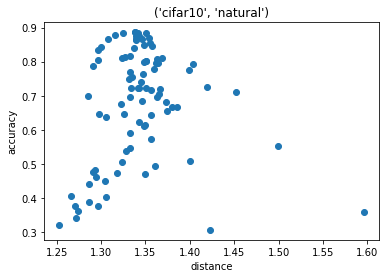

('cifar10', 'natural'): rho=0.103, p=0.336


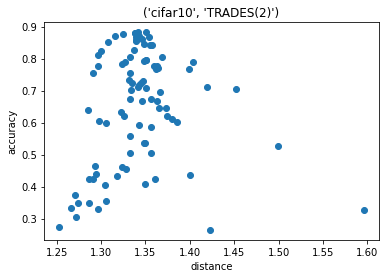

('cifar10', 'TRADES(2)'): rho=0.101, p=0.342


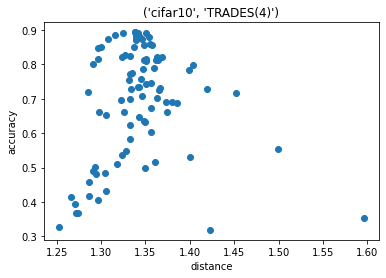

('cifar10', 'TRADES(4)'): rho=0.087, p=0.414


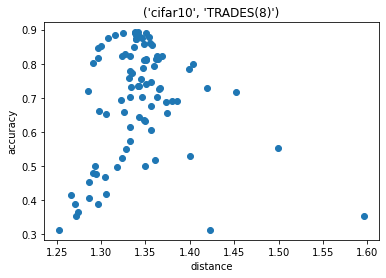

('cifar10', 'TRADES(8)'): rho=0.096, p=0.367


In [36]:
for i in range(4):
    aa = df[[f"dist_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names]].iloc[i].tolist()
    bb = df[[f"tstacc_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names]].iloc[i].tolist()
    plt.title(df.iloc[i].name)
    plt.scatter(aa, bb)
    plt.xlabel("distance")
    plt.ylabel("accuracy")
    plt.show()
    plt.close()
    res = scipy.stats.pearsonr(aa, bb)
    print(f"{df.iloc[i].name[0], df.iloc[i].name[1]}: rho={res[0]:.3f}, p={res[1]:.3f}")

## nat vs. rob

In [67]:
model_names = ['natural', 'TRADES(2)',]

df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
df = df.unstack(1).unstack(2)
df.columns = df.columns.droplevel(0)
for dset, dd in df.groupby("dataset"):
    dd.index = dd.index.droplevel(0)
    dd = dd[[(model_name, i) for model_name in model_names for i in range(1, 6)]]
    text = dd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace("0.", ".")
    text = text.replace("elastic\_transform", "elastic")
    text = text.replace("gaussian\_blur", "gblur")
    text = text.replace("speckle\_noise", "speckle")
    text = text.replace("jpeg\_compression", "jpeg")
    text = text.replace("\multicolumn{5}{l}", "\multicolumn{5}{c}")
    text = text.replace("lrrrrrrrrrrrrrrr", "lccccc|ccccc|ccccc")
    with open(f"./tex_files/corrupted_ncgs/{dset}.tex", "w") as f:
        f.write(text)

### Aggregated

In [70]:
model_names = ['natural', 'TRADES(2)']

df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
df = df.unstack(3).unstack(2)
df.columns = df.columns.droplevel(0)
results = {}

for dset, dd in df.groupby("dataset"):
    for model_name in model_names[1:]:
        results[dset] = [
            (np.array((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist()) > 0).sum(),
            "$%.2f \pm %.2f$" % (
                np.mean((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist()),
                scipy.stats.sem((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist())
            ),
        ]
ddff = pd.DataFrame.from_dict(results, orient="index", columns=["counts", "ratio"])
#ddff.index = pd.MultiIndex.from_tuples(ddff.index, names=["dataset",])
ddff = ddff[["counts", "ratio"]]
ddff = ddff.unstack(1)
text = ddff.to_latex(escape=False)
text = text.replace("cifar100coarse", "C100")
text = text.replace("cifar10", "C10")
text = text.replace("}{l}", "}{c}")
text = text.replace("0.", ".")
text = text.replace("lllllllll", "lcccc|cccc")
text = text.replace("lllllll", "lccc|ccc")
print(text)

\begin{tabular}{lll}
\toprule
      &                &                0 \\
\midrule
counts & cifar10 &               42 \\
      & cifar100coarse &               90 \\
ratio & cifar10 &  $1.00 \pm .00$ \\
      & cifar100coarse &  $1.07 \pm .00$ \\
\bottomrule
\end{tabular}



## NCG correct vs. NCG incorrect

In [ ]:
_, ood_names = get_ood_data_paths("cifar10", "not_matter")

preds, nnidxs, dists = joblib.load("nb_results/feature-cifar10-c.pkl")
res2 = joblib.load("nb_results/feature-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)']

data = {}
for key in preds.keys():
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    for ood_name in ood_names:
        _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == np.tile(tsty, 5))
        nnk1_ind = (trny[nnidxs[key][ood_name]] == np.tile(tsty, 5))
        if preds[key][ood_name].argmax(1).shape[0] != (len(tsty) * 5):
            import ipdb; ipdb.set_trace()

        for i in range(5):
            counts = 10000
            ttest = scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)])[ncg_ind[counts*i: counts*(i+1)] == 1],
                np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)] == 0)[ncg_ind[counts*i: counts*(i+1)] == 0],
                equal_var=False,
                alternative="greater",
            )
            data[(key[0], key[1], ood_name, i+1)] = [
                ncg_ind[counts*i: counts*(i+1)].mean(),
                tstacc_ind[counts*i: counts*(i+1)].mean(),
                np.logical_and(tstacc_ind, ncg_ind)[counts*i: counts*(i+1)].mean(),
                (np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)])[ncg_ind[counts*i: counts*(i+1)] == 1]).mean(),
                (np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)] == 0)[ncg_ind[counts*i: counts*(i+1)] == 0]).mean(),
                ttest[0],
                ttest[1],
                dists[key][ood_name][counts*i: counts*(i+1)].mean(),
                nnk1_ind[counts*i: counts*(i+1)].mean(),
            ]

In [ ]:
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc",
                                                           "[ttest] t-stats", "[ttest] p-value", "dist", '1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])

In [27]:
table_text = ""
table_text_template = """
\\begin{table}
  \centering
  \input{%s}
  \caption{%s}
  \label{tab:%s}
\end{table}
"""
for ood_name in ood_names:
    tdd = df[["NCG acc.", "tst acc.", "[NCG correct] tst acc", "[NCG incorrect] tst acc"]]
    tdd = tdd.loc[
        [("cifar10", "natural", ood_name, i+1) for i in range(5)]
        + [("cifar10", "TRADES(2)", ood_name, i+1) for i in range(5)]
        + [("cifar100coarse", "natural", ood_name, i+1) for i in range(5)]
        + [("cifar100coarse", "TRADES(2)", ood_name, i+1) for i in range(5)]
    ]
    tdd.index = tdd.index.droplevel(2)
    tdd = tdd.unstack(1)
    tdd.columns = tdd.columns.swaplevel(0, 1)
    tdd = tdd.sort_index(axis=1, level=0, ascending=False)
    text = tdd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace("cifar100coarse", "C100")
    text = text.replace("cifar10", "C10")
    text = text.replace("NCG acc.", "\\thead{NCG \\\\ acc.}")
    text = text.replace("tst acc.", "\\thead{tst \\\\ acc.}")
    text = text.replace("[NCG correct] tst acc", "\\thead{NCG \\\\ correct \\\\ tst acc.}")
    text = text.replace("[NCG incorrect] tst acc", "\\thead{NCG \\\\ incorrect \\\\ tst acc.}")
    text = text.replace("[ttest] p-value", "\\thead{p-value}")
    text = text.replace("dist", "\\thead{dist}")
    text = text.replace("}{l}", "}{c}")
    text = text.replace("llrrrrrrrr", "lccccc|cccc")
    with open(f"./tex_files/corrupted_ncg_acc_inter/feature_cifar_{ood_name}.tex", "w") as fp:
        fp.write(text)
    table_text += table_text_template % (
        f"./tables/corrupted_ncg_acc_inter/feature_cifar_{ood_name}.tex",
        f"The NCG score, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type {ood_name} in the feature space for naturally trained and robsut models.",
        f"corrupted_ncg_acc_inter_feature_cifar_{ood_name}",
    )


In [12]:
print(table_text)

### t-test

In [161]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index",
                            columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats",
                                     "[ttest] p-value", "dist", '1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    results[key] = (np.sum((dd["[ttest] t-stats"] > 0) & (dd["[ttest] p-value"] < 0.05)), len(dd["[ttest] t-stats"] > 0))
ttest_df = pd.DataFrame.from_dict(results, orient="index")
ttest_df.index = pd.MultiIndex.from_tuples(ttest_df.index)
ttest_df = ttest_df.unstack(0).unstack(0)
ttest_df.columns = ttest_df.columns.droplevel(0)
ttest_df.sum(0)

cifar10         TRADES(2)    90
                natural      88
cifar100coarse  TRADES(2)    90
                natural      89
cifar10         TRADES(2)    90
                natural      90
cifar100coarse  TRADES(2)    90
                natural      90
dtype: int64

### Control distance

In [62]:
_, ood_names = get_ood_data_paths("cifar10", "not_matter")

preds, nnidxs, dists = joblib.load("nb_results/feature-cifar10-c.pkl")
res2 = joblib.load("nb_results/feature-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])
model_names = ['natural', 'TRADES(2)']

bins = 5
control_dist_data = {}

for key in preds.keys():
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
    for ood_name in ood_names:
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == np.tile(tsty, 5))
        if preds[key][ood_name].argmax(1).shape[0] != (len(tsty) * 5):
            import ipdb; ipdb.set_trace()
            
        ncg_dists = dists[key][ood_name]
        sort_idx = np.argsort(ncg_dists)
        idxs = []
        for i in range(bins):
            idxs.append(sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins])

        ttests = []
        for i in range(bins):
            ttests.append(scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]])[ncg_ind[idxs[i]] == 1],
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]] == 0)[ncg_ind[idxs[i]] == 0],
                equal_var=False,
                alternative="greater",
            ))
        control_dist_data[(key[0], key[1], ood_name)] = [ttests, ]

('cifar10', 'natural')
('cifar10', 'TRADES(2)')
('cifar10', 'TRADES(4)')
('cifar10', 'TRADES(8)')
('cifar100coarse', 'natural')
('cifar100coarse', 'TRADES(2)')
('cifar100coarse', 'TRADES(4)')
('cifar100coarse', 'TRADES(8)')


In [63]:
results = {}
for k, v in control_dist_data.items():
    results.setdefault((k[0], k[1]), np.zeros(bins))
    for i in range(bins):
        if (v[0][i][0] > 0) and (v[0][i][1] < 0.01):
            results[(k[0], k[1])][i] += 1

In [19]:
results

{('cifar10', 'natural'): array([18., 18., 18., 18., 18.]),
 ('cifar10', 'TRADES(2)'): array([18., 18., 18., 18., 18.]),
 ('cifar100coarse', 'natural'): array([18., 18., 18., 18., 18.]),
 ('cifar100coarse', 'TRADES(2)'): array([18., 18., 18., 18., 18.])}

## Increase of corruption level

In [20]:
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)',]

### test accuracy

In [28]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["tst acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [231]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(18):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='greater'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([((t.pvalue < 0.05)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

cifar10
TRADES(2)
0
18
cifar100coarse
TRADES(2)
1
17


### NCG score

In [35]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc",
                                                           "[ttest] t-stats", "[ttest] p-value", "dist", '1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["NCG acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [233]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(18):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='greater'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([((t.pvalue < 0.05)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

cifar10
TRADES(2)
0
17
cifar100coarse
TRADES(2)
0
15


### Slope figure

In [59]:
df = pd.DataFrame.from_dict(data, orient="index", columns=['NCG acc.', 'tst acc.'] + [0]*6 + ['1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index)

In [60]:
ood_names = ['gaussian', 'impulse', 'shot', 'defocus', 'motion', 'zoom', 'glass', 'snow', 'fog', 'contrast', 'pixelate', 'brightness',
             'elastic_transform', 'gaussian_blur', 'jpeg_compression', 'saturate', 'spatter', 'speckle_noise']

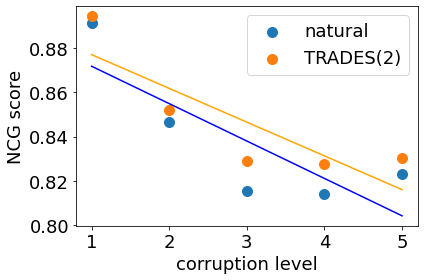

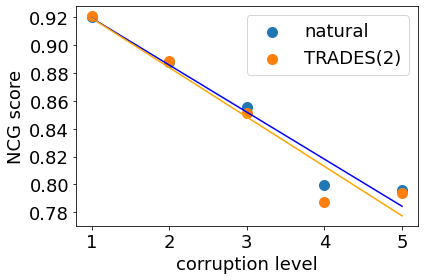

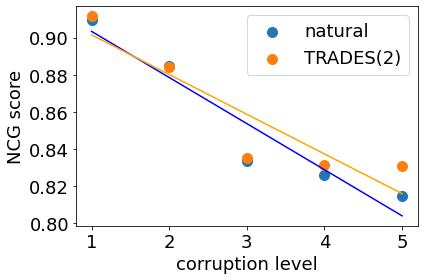

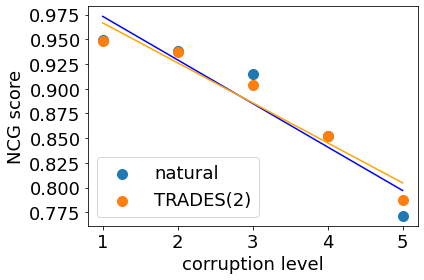

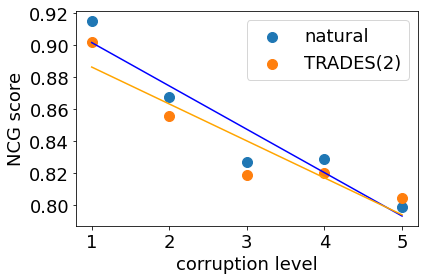

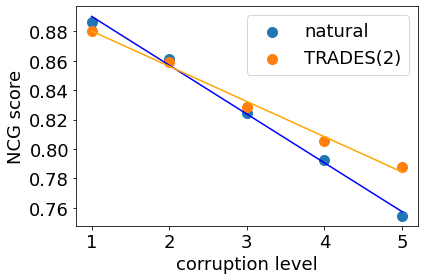

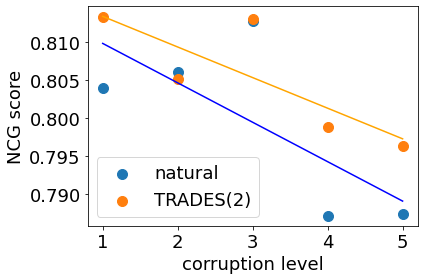

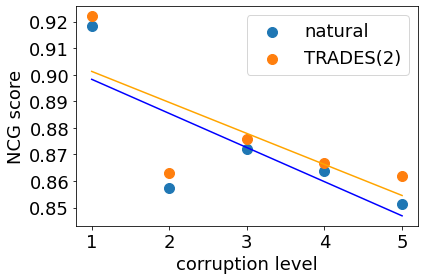

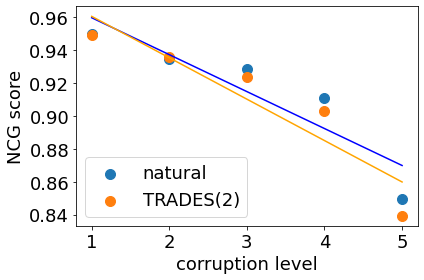

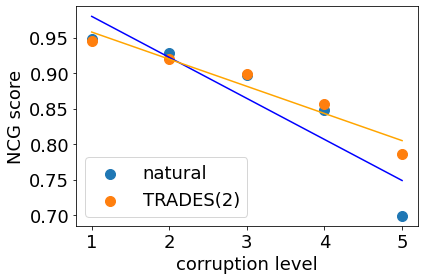

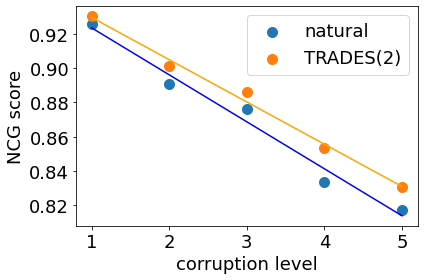

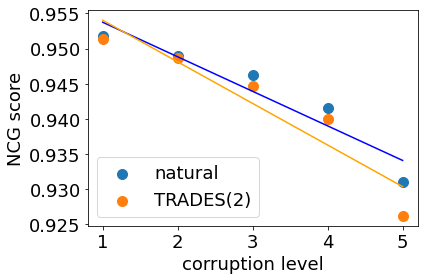

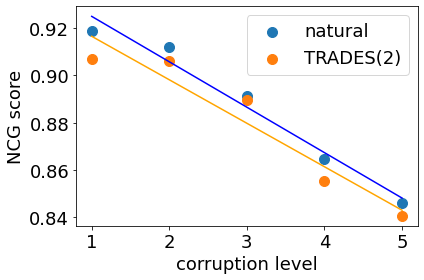

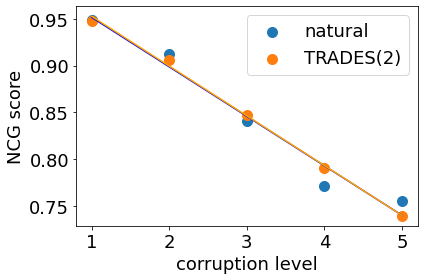

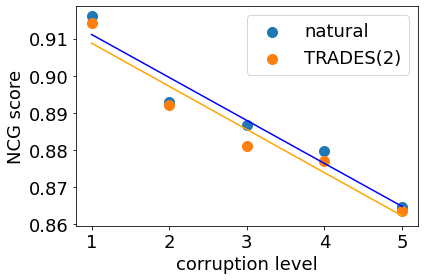

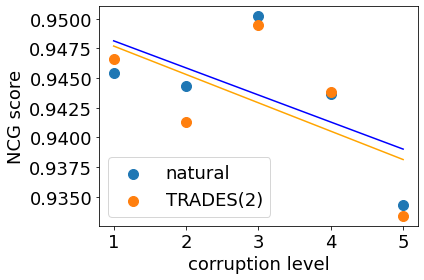

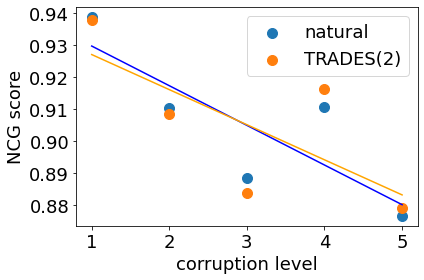

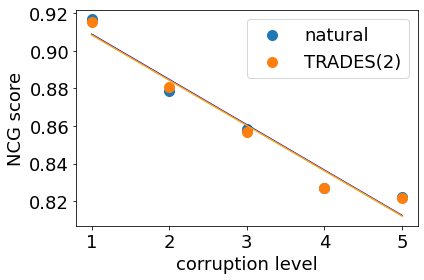

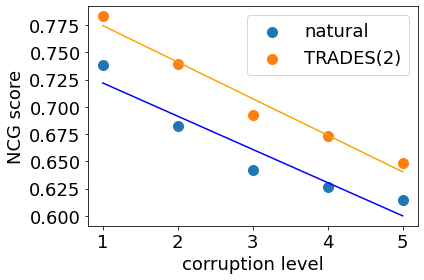

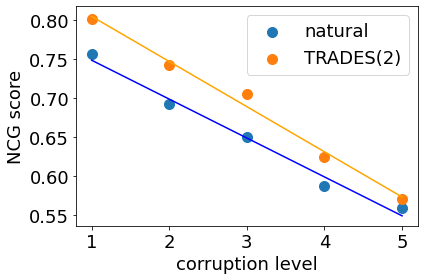

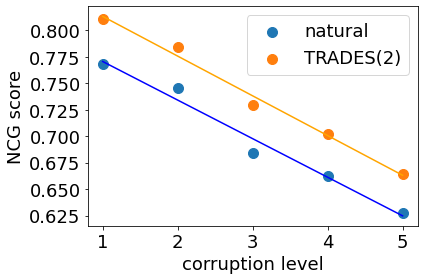

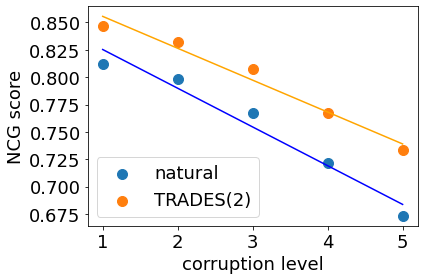

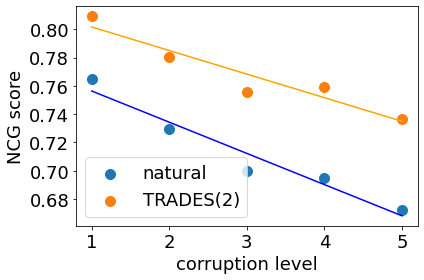

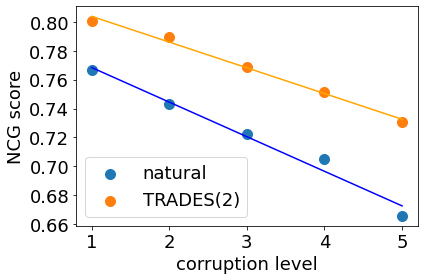

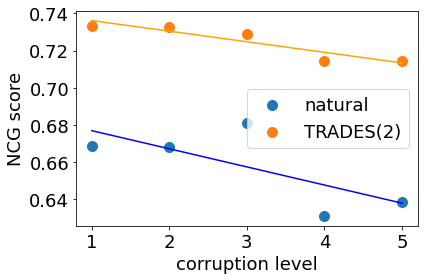

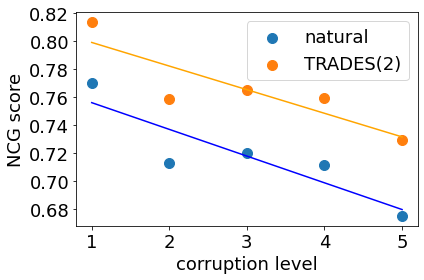

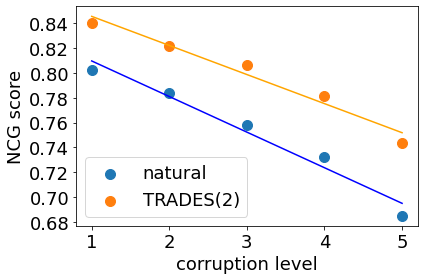

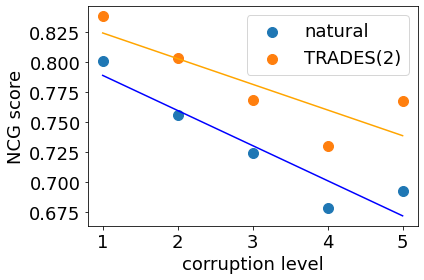

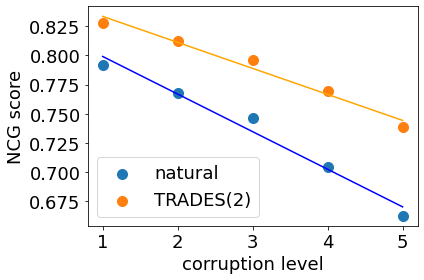

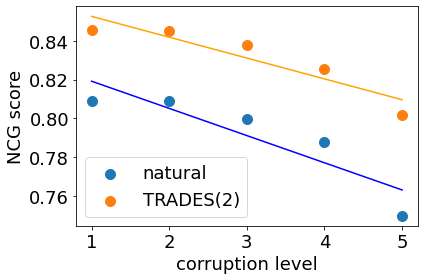

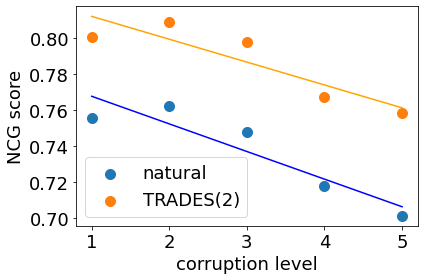

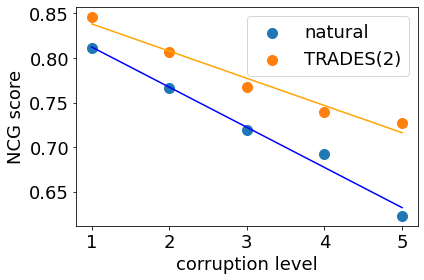

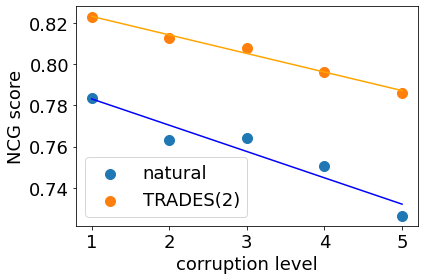

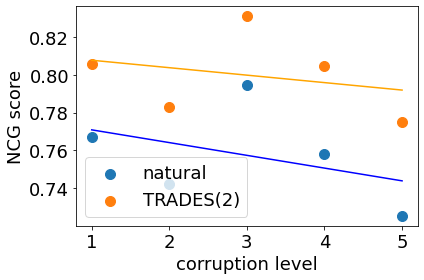

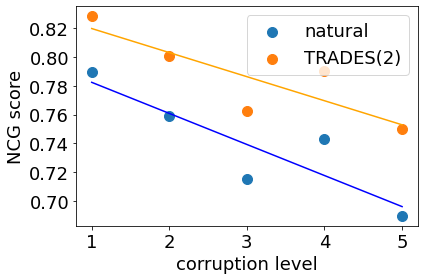

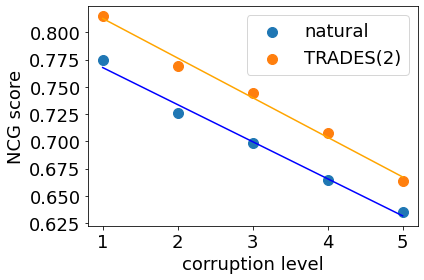

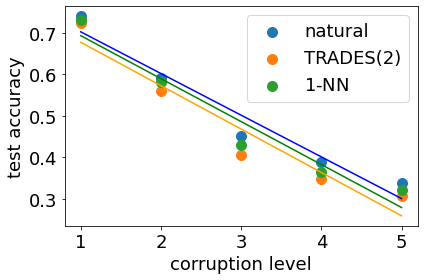

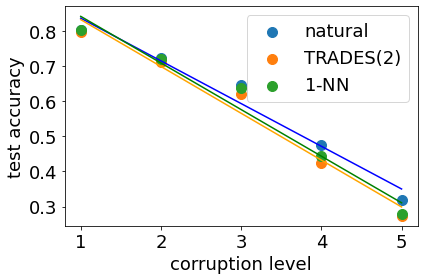

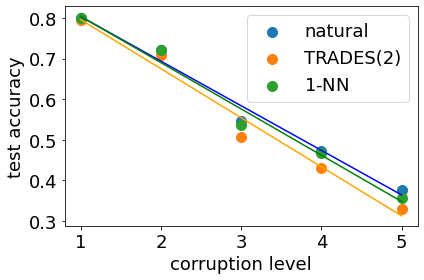

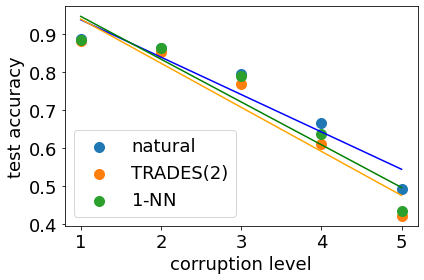

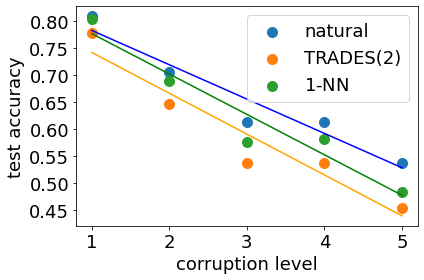

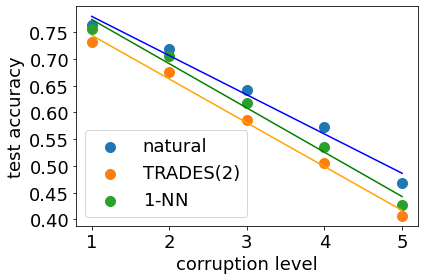

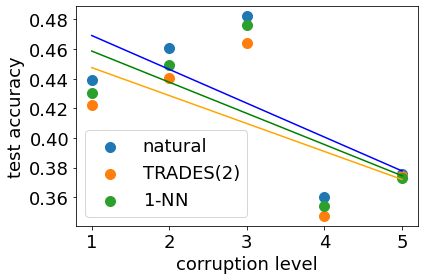

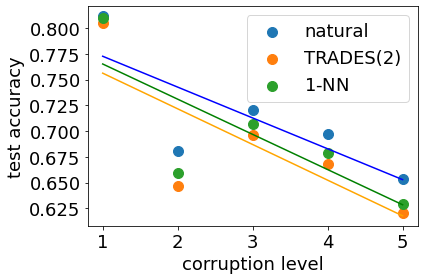

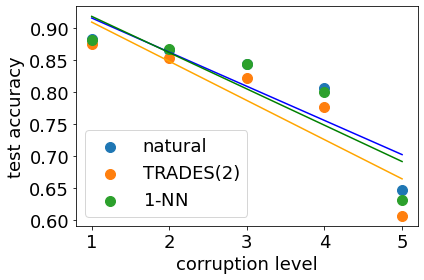

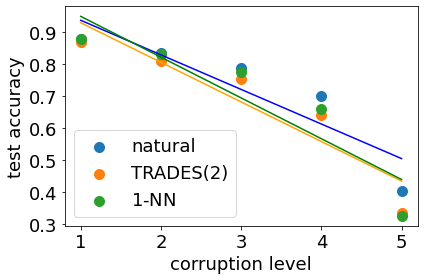

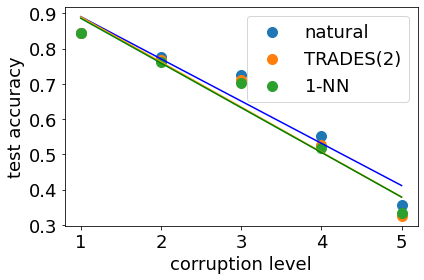

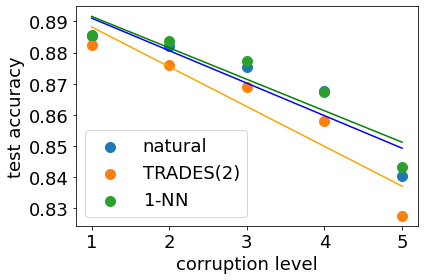

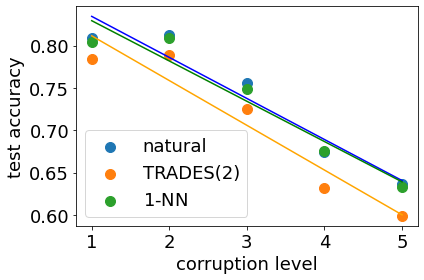

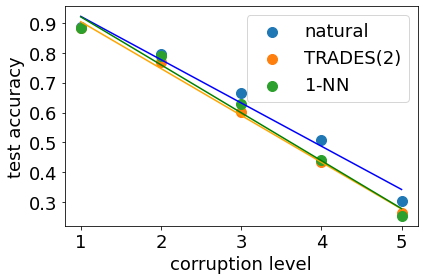

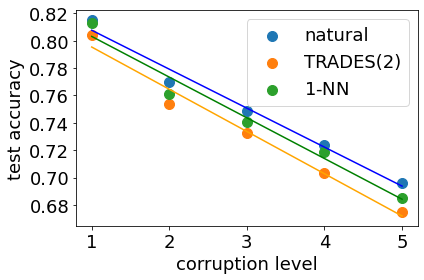

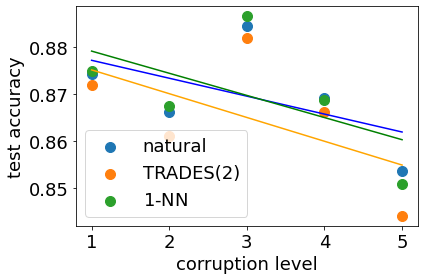

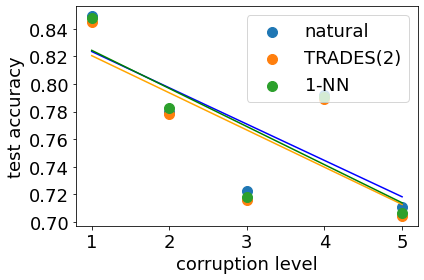

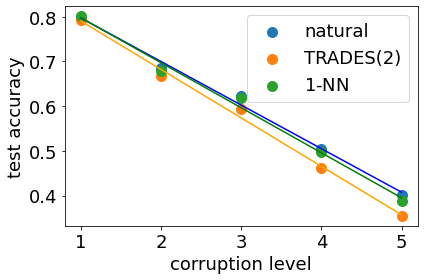

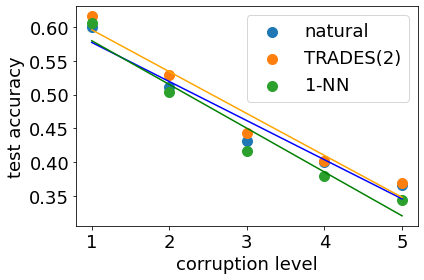

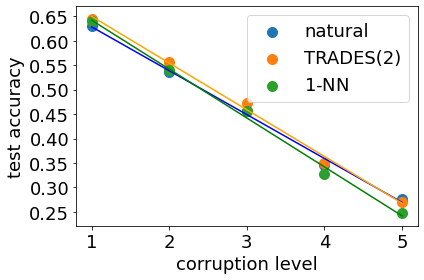

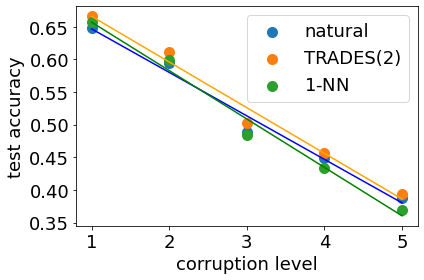

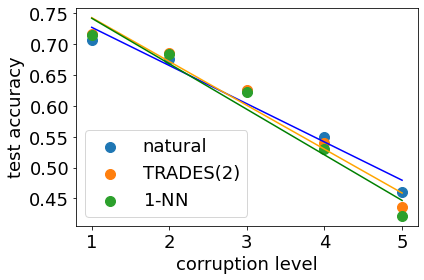

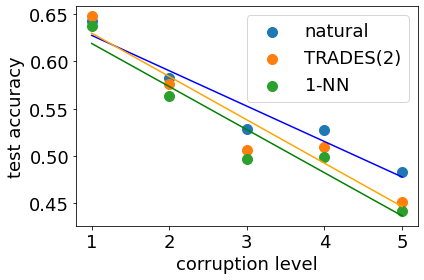

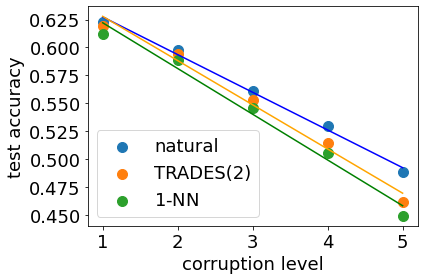

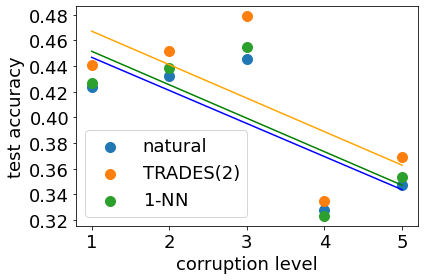

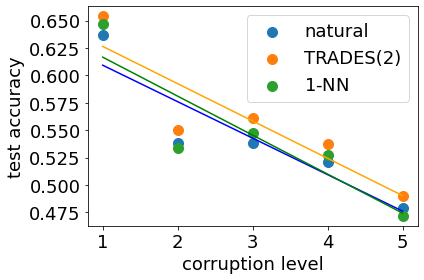

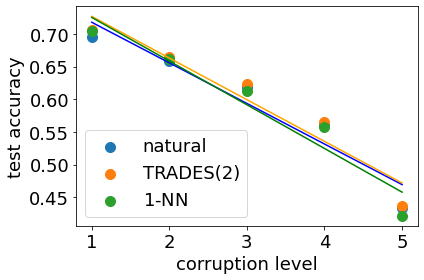

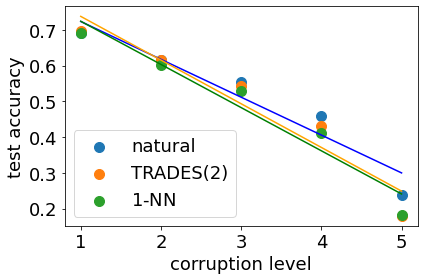

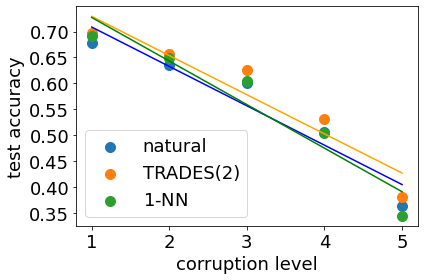

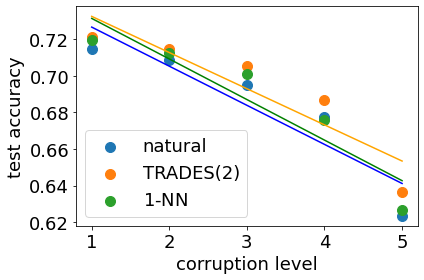

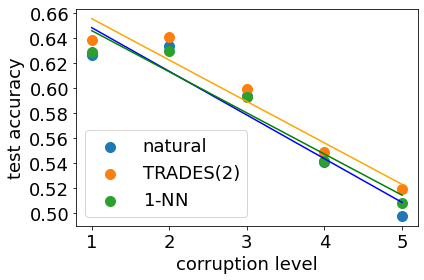

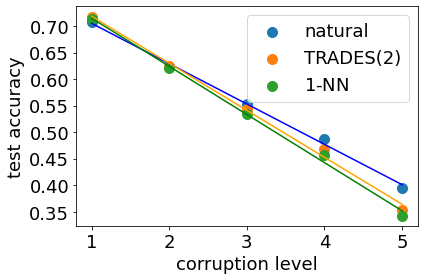

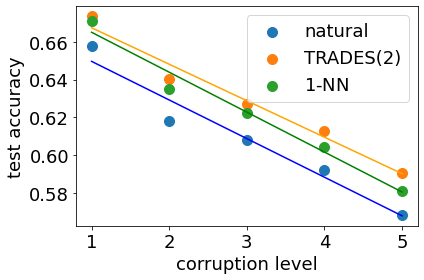

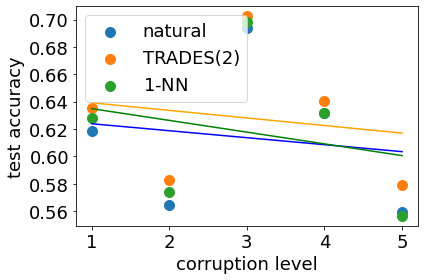

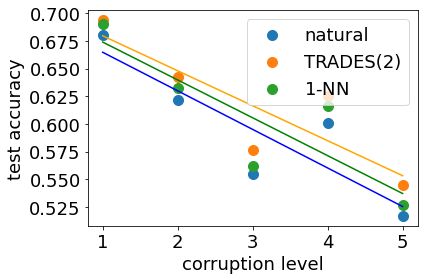

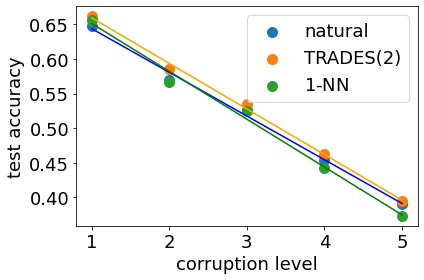

In [61]:
fontsize = 18
ds_names = ['cifar10', 'cifar100coarse']
for metric in ["ncg", "tstacc"]:
    for ds_name in ds_names:
        for ood_name in ood_names:
            if metric == "ncg":
                prefix = ""
                col_name = "NCG acc."
            elif metric == "tstacc":
                prefix = "tstacc_"
                col_name = "tst acc."
            points = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[[(ds_name, "natural", ood_name, i+1) for i in range(5)]][col_name].tolist()
            ]).T
            rob_pts = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[[(ds_name, "TRADES(2)", ood_name, i+1) for i in range(5)]][col_name].tolist()
            ]).T

            plt.scatter(points[:, 0], points[:, 1], s=100, label="natural")
            plt.scatter(rob_pts[:, 0], rob_pts[:, 1], s=100, label="TRADES(2)")

            def draw_regression_line(pts):
                gradient, intercept, _, _, _ = scipy.stats.linregress(pts[:, 0], pts[:, 1])
                x1=np.linspace(0, 1, 500)
                y1=gradient*x1 + intercept
                return gradient, x1, y1

            slope1, x1, y1 = draw_regression_line(points)
            plt.plot(x1, y1,'blue')
            slope2, x1, y1 = draw_regression_line(rob_pts)
            plt.plot(x1, y1,'orange')
            
            if metric == "tstacc":
                nnk1_pts = np.array([
                    (np.arange(5) / 4).tolist(),
                    df.loc[[(ds_name, "natural", ood_name, i+1) for i in range(5)]]['1nn acc.'].tolist()
                ]).T
                plt.scatter(nnk1_pts[:, 0], nnk1_pts[:, 1], s=100, label="$1$-NN")
                slope3, x1, y1 = draw_regression_line(nnk1_pts)
                plt.plot(x1, y1,'green')

            plt.legend(fontsize=fontsize)
            if metric == "ncg":
                plt.ylabel("NCG score", fontsize=fontsize)
            elif metric == "tstacc":
                plt.ylabel("test accuracy", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            plt.xlabel("corruption level", fontsize=fontsize)
            plt.xticks(np.arange(5) / 4, labels=[1, 2, 3, 4, 5], fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.tight_layout()
            slope1 = f"{slope1:.3f}".replace(".", "_")
            slope2 = f"{slope2:.3f}".replace(".", "_")
            plt.savefig(f"figs/slope_figs/feature_{metric}_{ds_name}_{ood_name}_{slope1}_{slope2}.png", bbox_inches='tight')
            plt.show()


In [174]:
df

NCG acc.  tst acc.    both  \
dataset        model     corruption    level                               
cifar10        natural   gaussian      0        0.8911    0.7400  0.6980   
                                       1        0.8464    0.5910  0.5380   
                                       2        0.8155    0.4505  0.3900   
                                       3        0.8140    0.3881  0.3274   
                                       4        0.8230    0.3388  0.2890   
...                                                ...       ...     ...   
cifar100coarse TRADES(2) speckle_noise 0        0.8146    0.6615  0.6034   
                                       1        0.7695    0.5857  0.5189   
                                       2        0.7446    0.5354  0.4669   
                                       3        0.7076    0.4620  0.3891   
                                       4        0.6638    0.3942  0.3229   

                                              [NCG correct] tst acc  \
dataset        model     corruption    level                          
cifar10        natural   gaussian      0                   0.783302   
                                       1                   0.635633   
                                       2                   0.478234   
                                       3                   0.402211   
                                       4                   0.351154   
...                                                             ...   
cifar100coarse TRADES(2) speckle_noise 0                   0.740732   
                                       1                   0.674334   
                                       2                   0.627048   
                                       3                   0.549887   
                                       4                   0.486442   

                                              [NCG incorrect] tst acc  \
dataset        model     corruption    level                            
cifar10        natural   gaussian      0                     0.385675   
                                       1                     0.345052   
                                       2                     0.327913   
                                       3                     0.326344   
                                       4                     0.281356   
...                                                               ...   
cifar100coarse TRADES(2) speckle_noise 0                     0.313376   
                                       1                     0.289805   
                                       2                     0.268207   
                                       3                     0.249316   
                                       4                     0.212076   

                                              [ttest] t-stats  \
dataset        model     corruption    level                    
cifar10        natural   gaussian      0            25.838608   
                                       1            21.991517   
                                       2            12.268870   
                                       3             6.240455   
                                       4             5.857619   
...                                                       ...   
cifar100coarse TRADES(2) speckle_noise 0            36.156945   
                                       1            35.417783   
                                       2            34.483188   
                                       3            30.206503   
                                       4            29.354870   

                                              [ttest] p-value      dist  
dataset        model     corruption    level                             
cifar10        natural   gaussian      0        3.289256e-119  1.344535  
                                       1         3.956342e-97  1.332452  
                                       2 

# Eval (nowo pixel)

In [51]:
ood_names = ['gaussian', 'impulse', 'shot', 'defocus', 'motion', 'zoom', 'glass', 'snow', 'fog', 'contrast', 'pixelate', 'brightness',
             'elastic_transform', 'gaussian_blur', 'jpeg_compression', 'saturate', 'spatter', 'speckle_noise']
model_names = [
    'natural',
    'TRADES(2)',
    'TRADES(4)',
    'TRADES(8)',
    'AT(2)',
]


In [40]:
preds, nnidxs, dists = joblib.load("nb_results/nowo-cifar10-c.pkl")
res2 = joblib.load("nb_results/nowo-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])

df = get_results(preds, nnidxs, dists)
df = df.stack(level=0).stack(level=0)[['tst acc'] \
                                      + [f"nnacc_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names] \
                                      + [f"overlap_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names] \
                                      + [f"{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names] \
                                      + [f"dist_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names] \
                                      + [f"tstacc_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names]]
df.index = pd.MultiIndex.from_tuples([i[1:] for i in df.index])
df = df.reindex(sorted(df.index, key=lambda x: (x[0], model_names.index(x[1]))))

ValueError: 'AT(2)' is not in list

In [58]:

a = []
for ood_name in ood_names:
    for i in range(1, 6):
        a.append(df[f"nnacc_{ood_name}_{i}"].mean())
np.mean(a)

0.2773527777777778

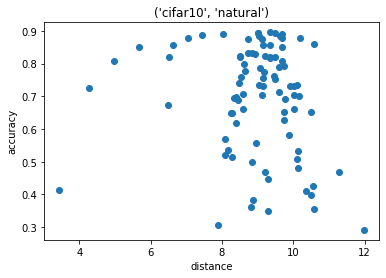

('cifar10', 'natural'): rho=-0.147, p=0.168


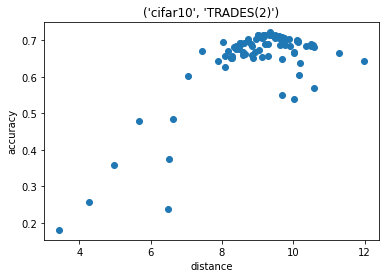

('cifar10', 'TRADES(2)'): rho=0.727, p=0.000


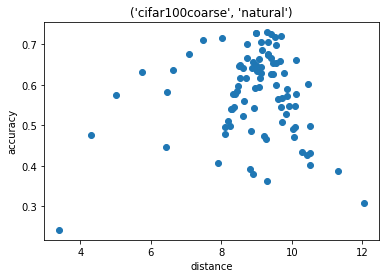

('cifar100coarse', 'natural'): rho=0.024, p=0.826


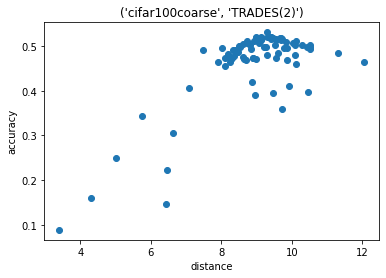

('cifar100coarse', 'TRADES(2)'): rho=0.733, p=0.000


In [34]:
for i in range(4):
    aa = df[[f"dist_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names]].iloc[i].tolist()
    bb = df[[f"tstacc_{ood_name}_{i}" for i in range(1, 6) for ood_name in ood_names]].iloc[i].tolist()
    plt.title(df.iloc[i].name)
    plt.scatter(aa, bb)
    plt.xlabel("distance")
    plt.ylabel("accuracy")
    plt.show()
    plt.close()
    res = scipy.stats.pearsonr(aa, bb)
    print(f"{df.iloc[i].name[0], df.iloc[i].name[1]}: rho={res[0]:.3f}, p={res[1]:.3f}")

In [22]:
df.iloc[0].name

('cifar10', 'natural')

## natural above chance

In [6]:
# scripts/get_preds_on_corrupted_feature
preds, nnidxs, dists = joblib.load("nb_results/nowo-cifar10-c.pkl")
res2 = joblib.load("nb_results/nowo-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])

datasets = ["cifar10", "cifar100coarse"]
ds_names = ["cifar10", "cifar100coarse"]

model_names = [
    'natural',
    'TRADES(2)',
]

data = {}
for ds_name, dataset in zip(ds_names, datasets):
    _, trny, _, _, _ = auto_var.get_var_with_argument("dataset", dataset)
    for model_name in model_names:
        key = (ds_name, model_name)
        if key not in preds:
            continue
            
        for ood_name in ood_names:
            res = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])

            chance_level = 1/19 if "cifar100coarse" in ds_name else 1/9
            counts = 10000
            for i in range(5):
                data[(ds_name, model_name, ood_name, i+1)] = res[i * counts: (i+1) * counts].mean()

In [85]:
model_names = ['natural', 'TRADES(2)',]

df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
df = df.unstack(1).unstack(2)
df.columns = df.columns.droplevel(0)
for dset, dd in df.groupby("dataset"):
    dd.index = dd.index.droplevel(0)
    dd = dd[[(model_name, i) for model_name in model_names for i in range(1, 6)]]
    text = dd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace("0.", ".")
    text = text.replace("elastic\_transform", "elastic")
    text = text.replace("gaussian\_blur", "gblur")
    text = text.replace("speckle\_noise", "speckle")
    text = text.replace("jpeg\_compression", "jpeg")
    text = text.replace("\multicolumn{5}{l}", "\multicolumn{5}{c}")
    text = text.replace("lrrrrrrrrrrrrrrr", "lccccc|ccccc|ccccc")
    with open(f"./tex_files/corrupted_ncgs/pixel-{dset}.tex", "w") as f:
        f.write(text)

### Aggregated

In [87]:
model_names = ['natural', 'TRADES(2)']

dff = pd.DataFrame.from_dict(data, orient="index")
dff.index = pd.MultiIndex.from_tuples(dff.index, names=["dataset", "model", "corruption", "level"])
dff = dff.unstack(3).unstack(2)
dff.columns = dff.columns.droplevel(0)
results = {}

for dset, dd in dff.groupby("dataset"):
    chance_level = 1/19 if "cifar100coarse" in ds_name else 1/9
    for model_name in model_names[1:]:
        results[dset] = [
            ((np.array(dd.loc[(dset, model_name)].tolist()) - chance_level) > 0).sum(),
            (np.array((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist()) > 0).sum(),
            "$%.2f \pm %.2f$" % (
                np.mean((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist()),
                scipy.stats.sem((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist())
            ),
        ]
ddff = pd.DataFrame.from_dict(results, orient="index", columns=["chance counts", "counts", "ratio"])
#ddff.index = pd.MultiIndex.from_tuples(ddff.index, names=["dataset",])
ddff = ddff[["chance counts", "counts", "ratio"]]
ddff = ddff.unstack(1)
text = ddff.to_latex(escape=False)
text = text.replace("cifar100coarse", "C100")
text = text.replace("cifar10", "C10")
text = text.replace("}{l}", "}{c}")
text = text.replace("0.", ".")
text = text.replace("lllllllll", "lcccc|cccc")
text = text.replace("lllllll", "lccc|ccc")
print(text)

\begin{tabular}{lll}
\toprule
      &                &                0 \\
\midrule
chance counts & C10 &               90 \\
      & C100 &               90 \\
counts & C10 &               90 \\
      & C100 &               90 \\
ratio & C10 &  $1.35 \pm .02$ \\
      & C100 &  $1.36 \pm .03$ \\
\bottomrule
\end{tabular}



In [72]:
datasets = [f"cifar10"] + [f"cifar100coarse"]

model_names = [
    'natural',
    'TRADES(2)',
    'TRADES(4)',
    'TRADES(8)',
    'AT(2)',
]

total, below = 0, 0
for ds_name in datasets:
    _, trny, _, _, _ = auto_var.get_var_with_argument("dataset", ds_name)
    for model_name in model_names:
        key = (ds_name, model_name)
        if key not in preds:
            continue
            
        for ood_name in ood_names:
            res = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])

            counts = 10000
            chance_level = 1/19 if "cifar100coarse" in ds_name else 1/9
            for i in range(5):
                total += 1
                if res[i * counts: (i+1) * counts].mean() < chance_level:
                    below += 1


## NCG correct vs. NCG incorrect

In [50]:
_, ood_names = get_ood_data_paths("cifar10", "not_matter")

preds, nnidxs, dists = joblib.load("nb_results/nowo-cifar10-c.pkl")
res2 = joblib.load("nb_results/nowo-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)']

data = {}
for key in preds.keys():
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    for ood_name in ood_names:
        _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == np.tile(tsty, 5))
        nnk1_ind = (trny[nnidxs[key][ood_name]] == np.tile(tsty, 5))
        if preds[key][ood_name].argmax(1).shape[0] != (len(tsty) * 5):
            import ipdb; ipdb.set_trace()

        for i in range(5):
            counts = 10000
            ttest = scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)])[ncg_ind[counts*i: counts*(i+1)] == 1],
                np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)] == 0)[ncg_ind[counts*i: counts*(i+1)] == 0],
                equal_var=False,
                alternative="greater",
            )
            data[(key[0], key[1], ood_name, i+1)] = [
                ncg_ind[counts*i: counts*(i+1)].mean(),
                tstacc_ind[counts*i: counts*(i+1)].mean(),
                np.logical_and(tstacc_ind, ncg_ind)[counts*i: counts*(i+1)].mean(),
                (np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)])[ncg_ind[counts*i: counts*(i+1)] == 1]).mean(),
                (np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)] == 0)[ncg_ind[counts*i: counts*(i+1)] == 0]).mean(),
                ttest[0],
                ttest[1],
                dists[key][ood_name][counts*i: counts*(i+1)].mean(),
                nnk1_ind[counts*i: counts*(i+1)].mean(),
            ]

In [51]:
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc",
                                                           "[ttest] t-stats", "[ttest] p-value", "dist", '1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])

In [28]:
table_text = ""
table_text_template = """
\\begin{table}
  \centering
  \input{%s}
  \caption{%s}
  \label{tab:%s}
\end{table}
"""
for ood_name in ood_names:
    tdd = df[["NCG acc.", "tst acc.", "[NCG correct] tst acc", "[NCG incorrect] tst acc"]]
    tdd = tdd.loc[
        [("cifar10", "natural", ood_name, i+1) for i in range(5)]
        + [("cifar10", "TRADES(2)", ood_name, i+1) for i in range(5)]
        + [("cifar100coarse", "natural", ood_name, i+1) for i in range(5)]
        + [("cifar100coarse", "TRADES(2)", ood_name, i+1) for i in range(5)]
    ]
    tdd.index = tdd.index.droplevel(2)
    tdd = tdd.unstack(1)
    tdd.columns = tdd.columns.swaplevel(0, 1)
    tdd = tdd.sort_index(axis=1, level=0, ascending=False)
    text = tdd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace("cifar100coarse", "C100")
    text = text.replace("cifar10", "C10")
    text = text.replace("NCG acc.", "\\thead{NCG \\\\ acc.}")
    text = text.replace("tst acc.", "\\thead{tst \\\\ acc.}")
    text = text.replace("[NCG correct] tst acc", "\\thead{NCG \\\\ correct \\\\ tst acc.}")
    text = text.replace("[NCG incorrect] tst acc", "\\thead{NCG \\\\ incorrect \\\\ tst acc.}")
    text = text.replace("[ttest] p-value", "\\thead{p-value}")
    text = text.replace("dist", "\\thead{dist}")
    text = text.replace("}{l}", "}{c}")
    text = text.replace("llrrrrrrrr", "lccccc|cccc")
    with open(f"./tex_files/corrupted_ncg_acc_inter/pixel_cifar_{ood_name}.tex", "w") as fp:
        fp.write(text)
    table_text += table_text_template % (
        f"./tables/corrupted_ncg_acc_inter/pixel_cifar_{ood_name}.tex",
        f"The NCG score, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type {ood_name} in the pixel space for naturally trained and robsut models.",
        f"corrupted_ncg_acc_inter_pixel_cifar_{ood_name}",
    )

In [16]:
print(table_text)


\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/pixel_cifar_gaussian.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type gaussian in the pixel space for naturally trained and robsut models.}
  \label{tab:corrupted_ncg_acc_inter_pixel_cifar_gaussian}
\end{table}

\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/pixel_cifar_impulse.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type impulse in the pixel space for naturally trained and robsut models.}
  \label{tab:corrupted_ncg_acc_inter_pixel_cifar_impulse}
\end{table}

\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/pixel_cifar_shot.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type shot in the pixel space for naturally trained and robsut models.}
  \label{tab:corr

### t-test

In [237]:
results = {}
df = pd.DataFrame.from_dict(data,
                            orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    results[key] = (np.sum((dd["[ttest] t-stats"] > 0) & (dd["[ttest] p-value"] < 0.05)), len(dd["[ttest] t-stats"] > 0))
ttest_df = pd.DataFrame.from_dict(results, orient="index")
ttest_df.index = pd.MultiIndex.from_tuples(ttest_df.index)
ttest_df = ttest_df.unstack(0).unstack(0)
ttest_df.columns = ttest_df.columns.droplevel(0)
ttest_df.sum(0)

cifar10         TRADES(2)    84
                natural      87
cifar100coarse  TRADES(2)    88
                natural      87
cifar10         TRADES(2)    90
                natural      90
cifar100coarse  TRADES(2)    90
                natural      90
dtype: int64

## Increase of corruption level

In [238]:
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)',]

### test accuracy

In [46]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc",
                                                           "[ttest] t-stats", "[ttest] p-value", "dist", '1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["tst acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [250]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(18):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='less'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([((t.pvalue < 0.05)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

cifar10
TRADES(2)
15
3
cifar100coarse
TRADES(2)
14
4


### NCG score

In [47]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc",
                                                           "[ttest] t-stats", "[ttest] p-value", "dist", '1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["NCG acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [247]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(18):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='less'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([((t.pvalue < 0.05) and (t.statistic < 0.)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

cifar10
TRADES(2)
15
3
cifar100coarse
TRADES(2)
14
4


In [248]:
greater_ttests

[Ttest_indResult(statistic=-5.212162893486313, pvalue=0.0023228572970170457),
 Ttest_indResult(statistic=-3.7217900859432174, pvalue=0.002968804761052082),
 Ttest_indResult(statistic=-8.397816312818653, pvalue=9.599084043017308e-05),
 Ttest_indResult(statistic=-3.4672941689069714, pvalue=0.006675496884404467),
 Ttest_indResult(statistic=-0.39039949748178254, pvalue=0.35351695834450925),
 Ttest_indResult(statistic=-7.5268107138512885, pvalue=3.822255326085618e-05),
 Ttest_indResult(statistic=-16.699283943520808, pvalue=9.957530194747172e-08),
 Ttest_indResult(statistic=-1.6329787344813274, pvalue=0.0723747747871573),
 Ttest_indResult(statistic=-4.354923818130063, pvalue=0.0012355116552078035),
 Ttest_indResult(statistic=-5.011927095291437, pvalue=0.0009377930454556136),
 Ttest_indResult(statistic=-3.483684482896791, pvalue=0.005615438946101553),
 Ttest_indResult(statistic=-3.9522325338682744, pvalue=0.00825640278896451),
 Ttest_indResult(statistic=-0.558429390735922, pvalue=0.2963221044

### Slope figure

In [52]:
ood_names = ['gaussian', 'impulse', 'shot', 'defocus', 'motion', 'zoom', 'glass', 'snow', 'fog', 'contrast', 'pixelate', 'brightness',
             'elastic_transform', 'gaussian_blur', 'jpeg_compression', 'saturate', 'spatter', 'speckle_noise']

In [53]:
_, ood_names = get_ood_data_paths("cifar10", "not_matter")

preds, nnidxs, dists = joblib.load("nb_results/nowo-cifar10-c.pkl")
res2 = joblib.load("nb_results/nowo-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)']

data = {}
for key in preds.keys():
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
    for ood_name in ood_names:
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == np.tile(tsty, 5))
        nnk1_ind = (trny[nnidxs[key][ood_name]] == np.tile(tsty, 5))
        if preds[key][ood_name].argmax(1).shape[0] != (len(tsty) * 5):
            import ipdb; ipdb.set_trace()

        for i in range(5):
            counts = 10000
            ttest = scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)])[ncg_ind[counts*i: counts*(i+1)] == 1],
                np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)] == 0)[ncg_ind[counts*i: counts*(i+1)] == 0],
                equal_var=False,
                alternative="greater",
            )
            data[(key[0], key[1], ood_name, i)] = [
                ncg_ind[counts*i: counts*(i+1)].mean(),
                tstacc_ind[counts*i: counts*(i+1)].mean(),
                np.logical_and(tstacc_ind, ncg_ind)[counts*i: counts*(i+1)].mean(),
                (np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)])[ncg_ind[counts*i: counts*(i+1)] == 1]).mean(),
                (np.logical_and(tstacc_ind[counts*i: counts*(i+1)], ncg_ind[counts*i: counts*(i+1)] == 0)[ncg_ind[counts*i: counts*(i+1)] == 0]).mean(),
                ttest[0],
                ttest[1],
                dists[key][ood_name][counts*i: counts*(i+1)].mean(),
                nnk1_ind[counts*i: counts*(i+1)].mean(),
            ]

('cifar10', 'natural')
('cifar10', 'TRADES(2)')
('cifar10', 'AT(2)')
('cifar100coarse', 'natural')
('cifar100coarse', 'TRADES(2)')
('cifar100coarse', 'AT(2)')


In [54]:
df = pd.DataFrame.from_dict(data, orient="index", columns=['NCG acc.', 'tst acc.'] + [0]*6 + ['1nn acc.'])
df.index = pd.MultiIndex.from_tuples(df.index)
#df = df.unstack(2)
#df.columns = df.columns.droplevel(0)

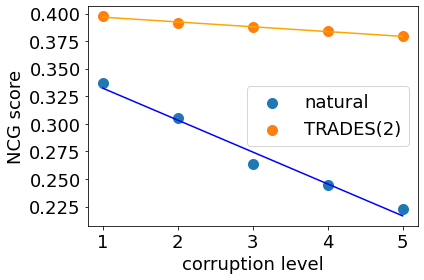

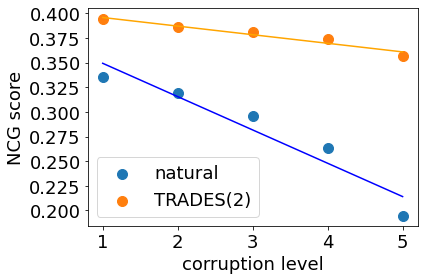

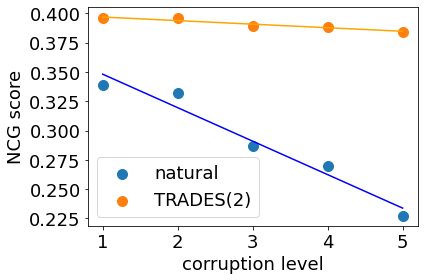

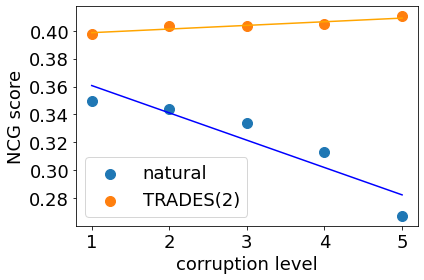

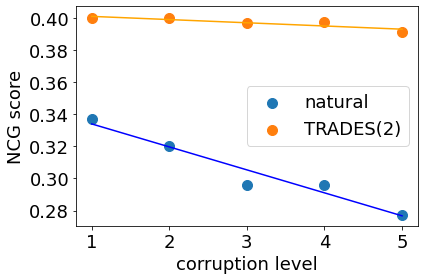

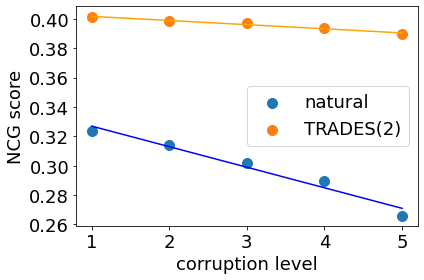

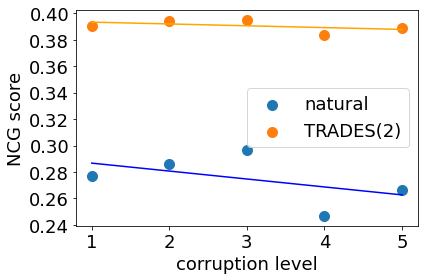

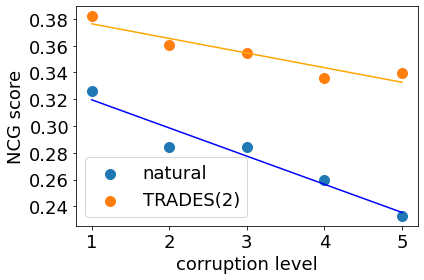

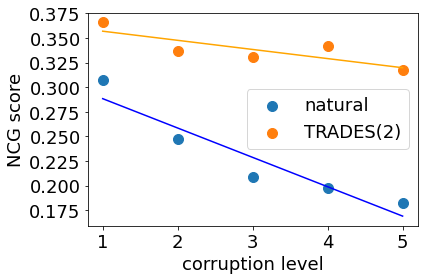

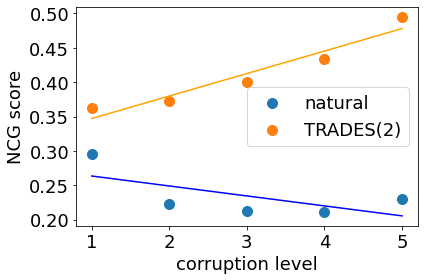

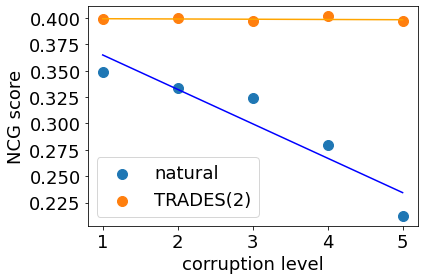

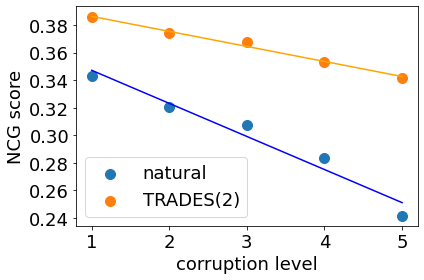

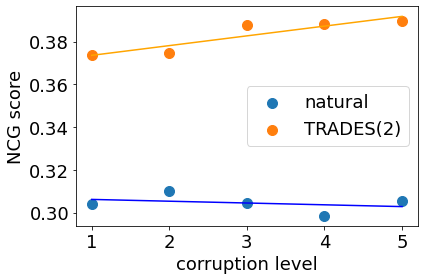

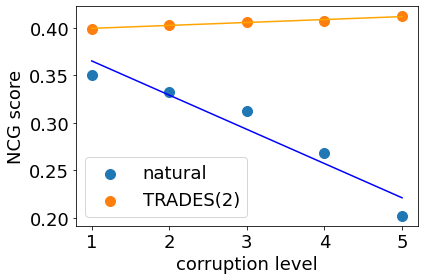

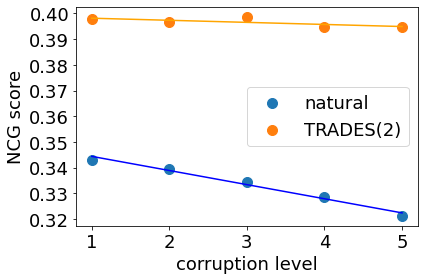

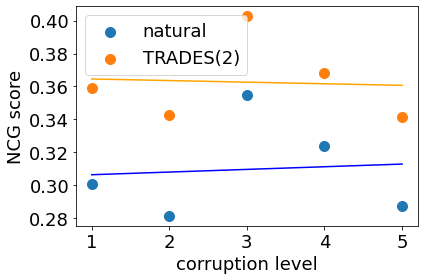

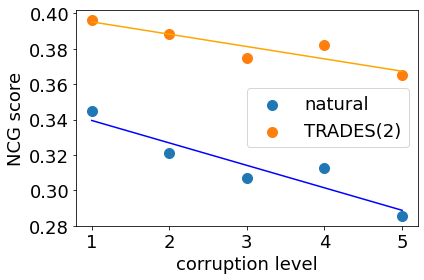

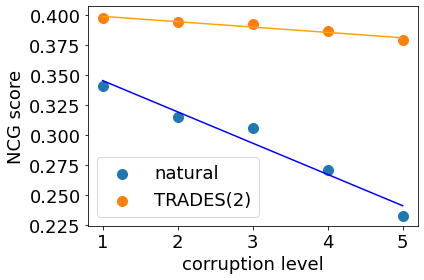

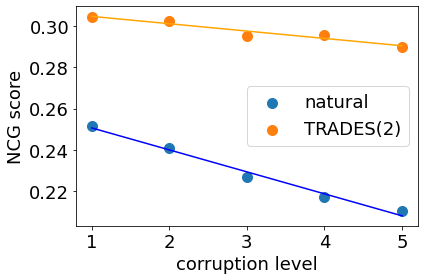

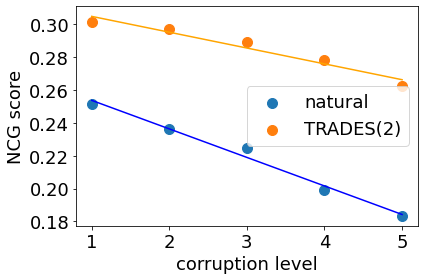

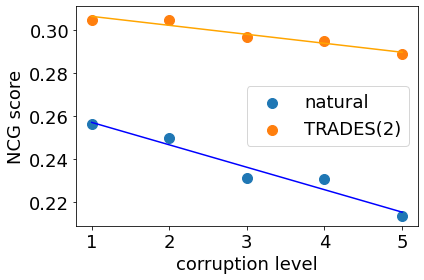

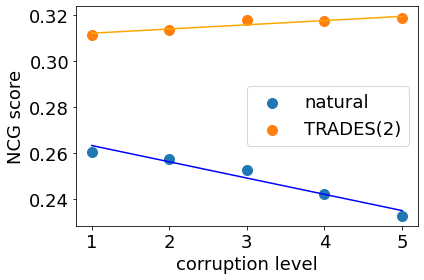

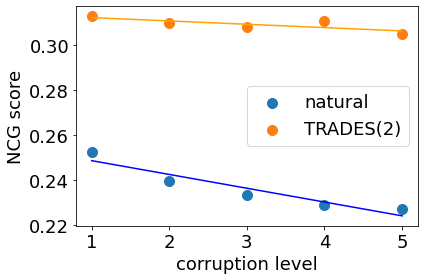

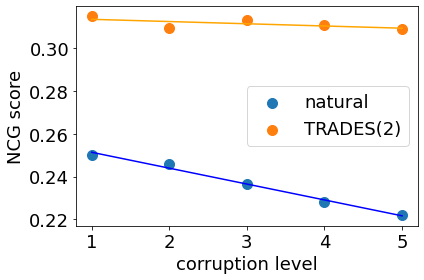

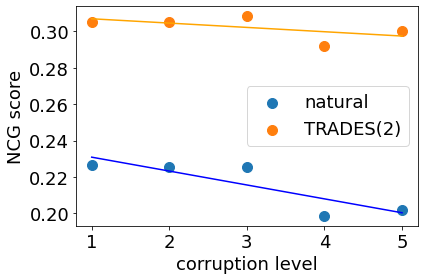

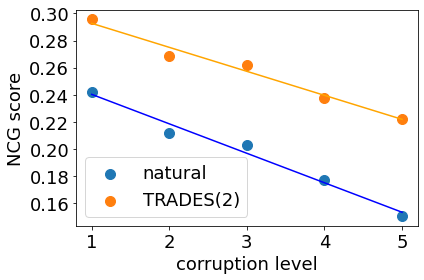

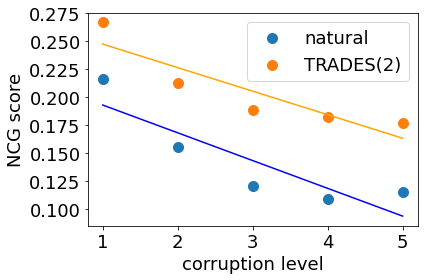

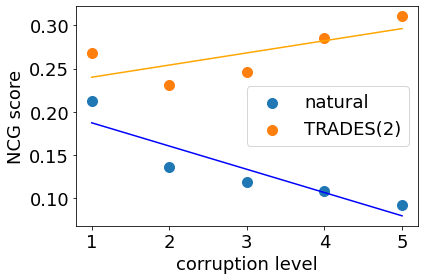

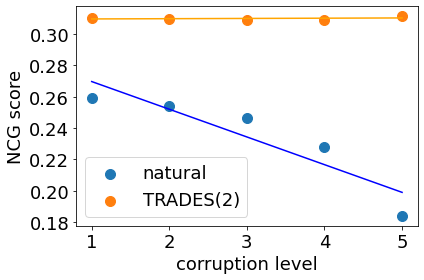

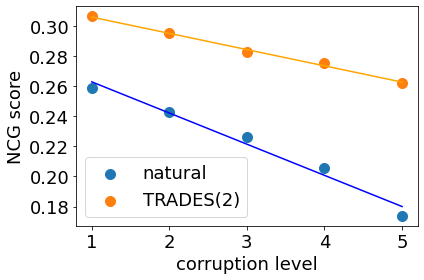

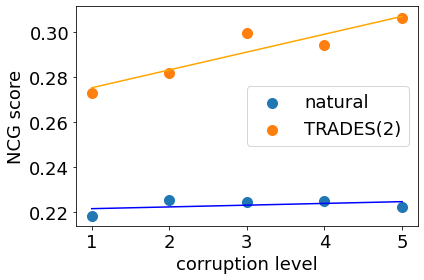

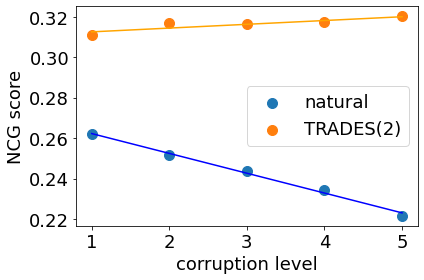

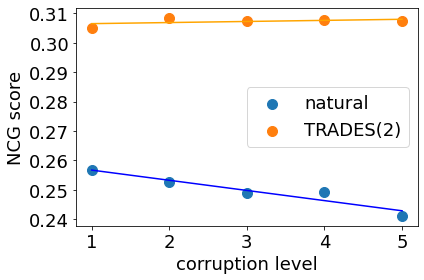

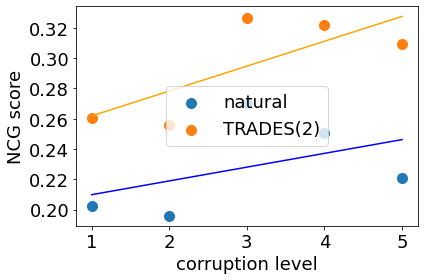

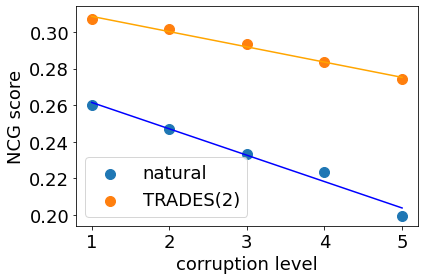

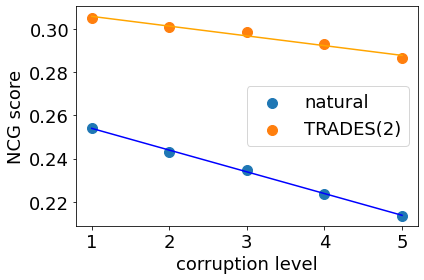

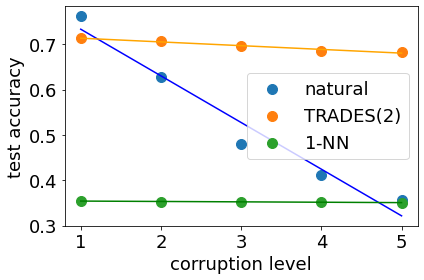

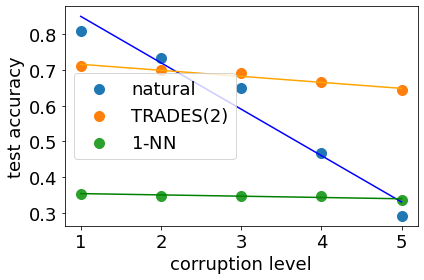

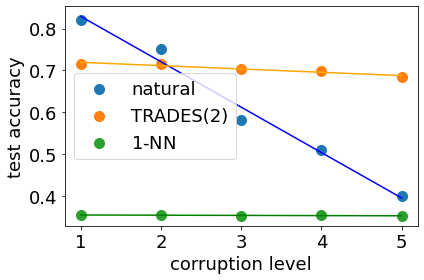

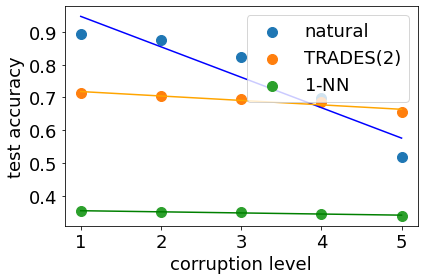

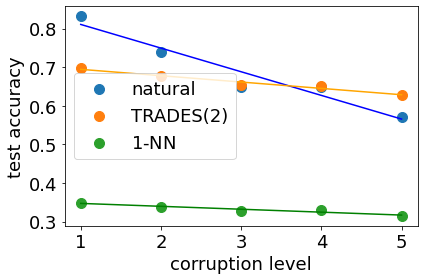

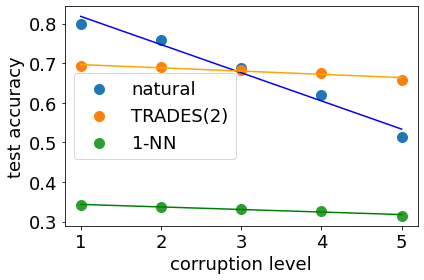

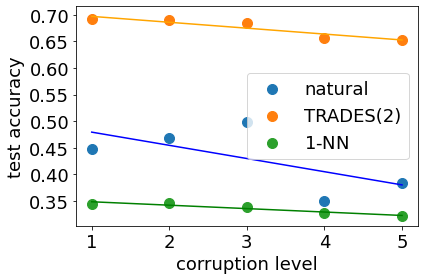

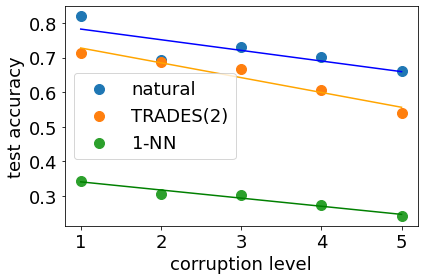

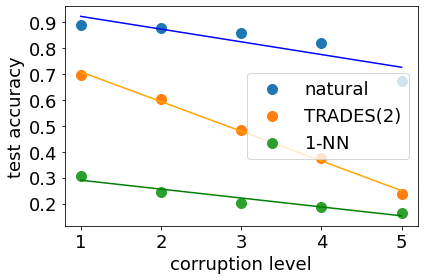

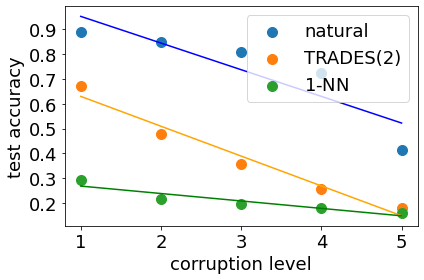

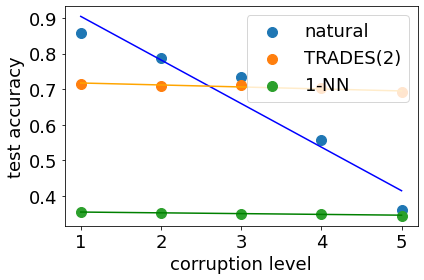

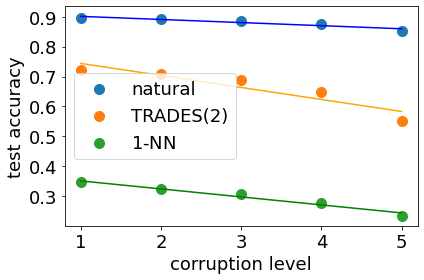

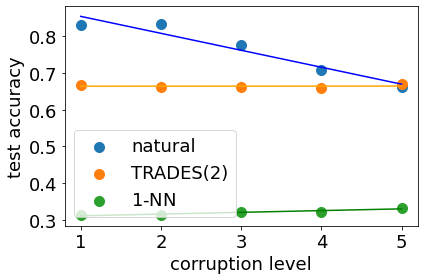

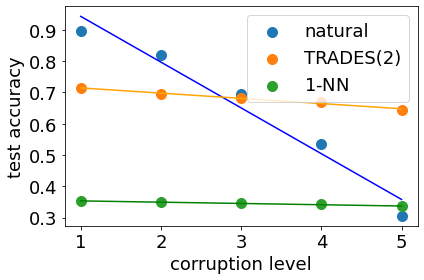

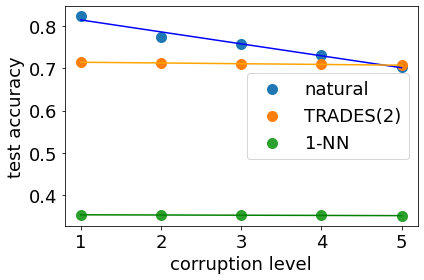

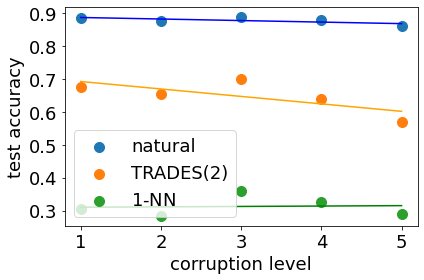

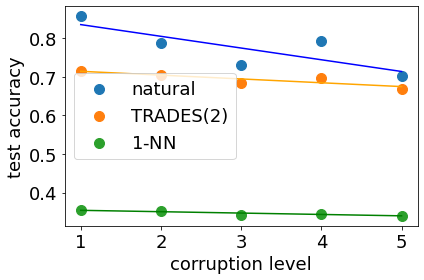

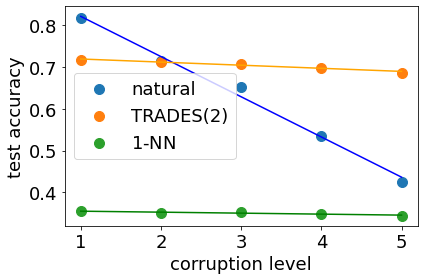

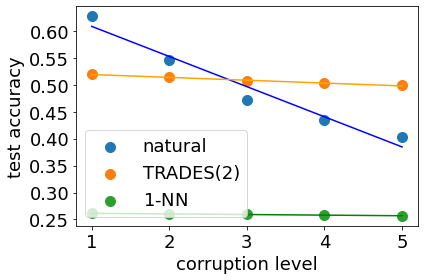

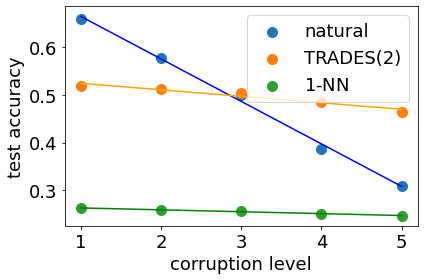

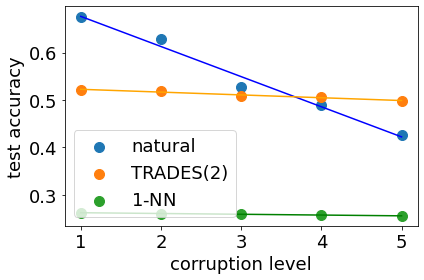

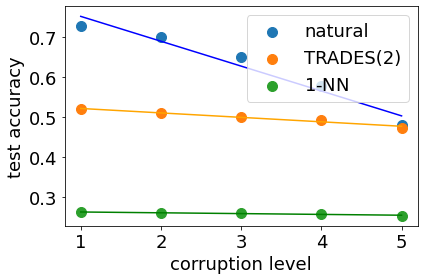

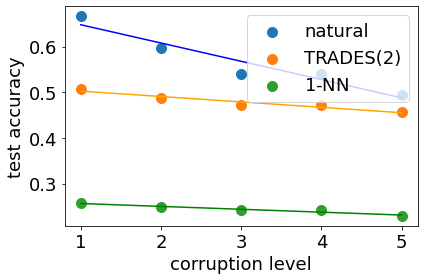

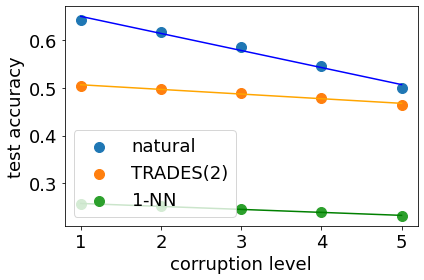

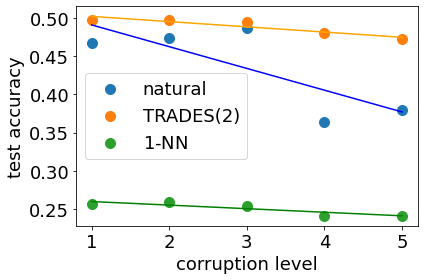

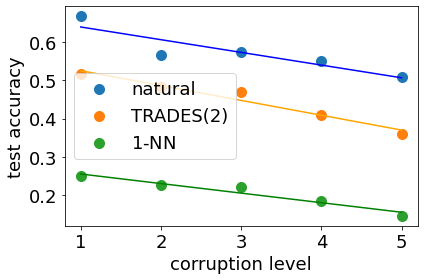

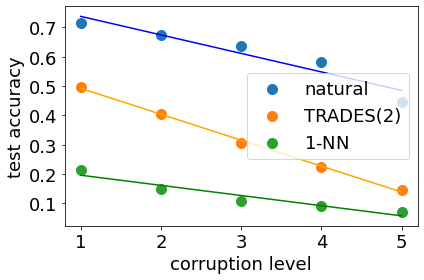

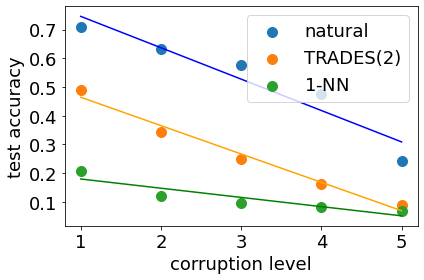

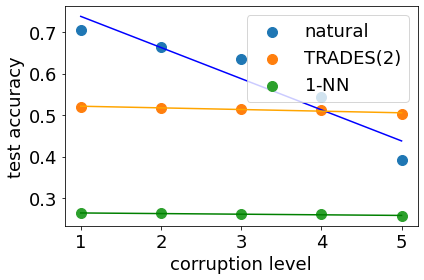

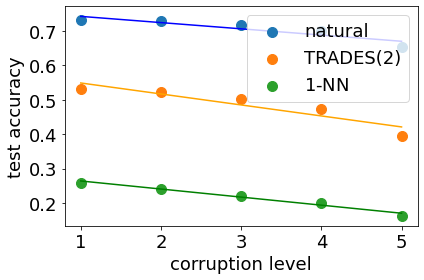

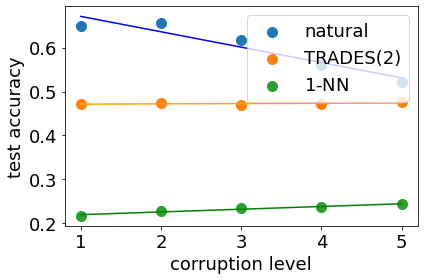

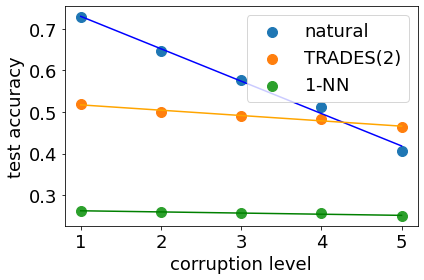

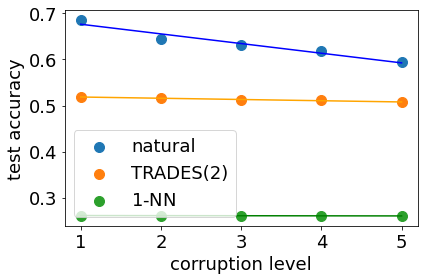

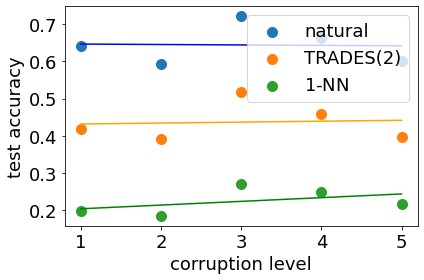

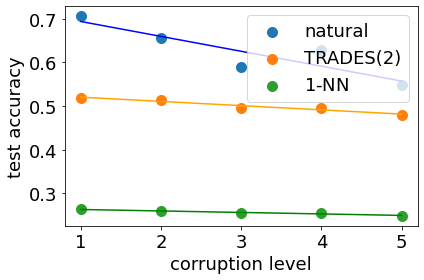

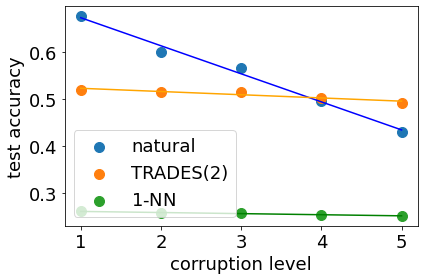

In [56]:
fontsize = 18
ds_names = ['cifar10', 'cifar100coarse']
for metric in ["ncg", "tstacc"]:
    for ds_name in ds_names:
        for ood_name in ood_names:
            if metric == "ncg":
                col_name = "NCG acc."
            elif metric == "tstacc":
                col_name = "tst acc."
            points = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[[(ds_name, "natural", ood_name, i) for i in range(5)]][col_name].tolist()
            ]).T
            rob_pts = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[[(ds_name, "TRADES(2)", ood_name, i) for i in range(5)]][col_name].tolist()
            ]).T
            plt.scatter(points[:, 0], points[:, 1], s=100, label="natural")
            plt.scatter(rob_pts[:, 0], rob_pts[:, 1], s=100, label="TRADES(2)")

            def draw_regression_line(pts):
                gradient, intercept, _, _, _ = scipy.stats.linregress(pts[:, 0], pts[:, 1])
                x1=np.linspace(0, 1, 500)
                y1=gradient*x1 + intercept
                return gradient, x1, y1

            slope1, x1, y1 = draw_regression_line(points)
            plt.plot(x1, y1,'blue')
            slope2, x1, y1 = draw_regression_line(rob_pts)
            plt.plot(x1, y1,'orange')
            
            if metric == "tstacc":
                nnk1_pts = np.array([
                    (np.arange(5) / 4).tolist(),
                    df.loc[[(ds_name, "natural", ood_name, i) for i in range(5)]]['1nn acc.'].tolist()
                ]).T
                plt.scatter(nnk1_pts[:, 0], nnk1_pts[:, 1], s=100, label="$1$-NN")
                slope3, x1, y1 = draw_regression_line(nnk1_pts)
                plt.plot(x1, y1,'green')


            plt.legend(fontsize=fontsize)
            if metric == "ncg":
                plt.ylabel("NCG score", fontsize=fontsize)
            elif metric == "tstacc":
                plt.ylabel("test accuracy", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            plt.xlabel("corruption level", fontsize=fontsize)
            plt.xticks(np.arange(5) / 4, labels=[1, 2, 3, 4, 5], fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.tight_layout()
            slope1 = f"{slope1:.3f}".replace(".", "_")
            slope2 = f"{slope2:.3f}".replace(".", "_")
            plt.savefig(f"figs/slope_figs/{metric}_{ds_name}_{ood_name}_{slope1}_{slope2}.png", bbox_inches='tight')
            plt.show()


### Control

In [38]:
_, ood_names = get_ood_data_paths("cifar10", "not_matter")

preds, nnidxs, dists = joblib.load("nb_results/nowo-cifar10-c.pkl")
res2 = joblib.load("nb_results/nowo-cifar100-c.pkl")
preds.update(res2[0])
nnidxs.update(res2[1])
dists.update(res2[2])
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)']

bins = 5
control_dist_data = {}

for key in preds.keys():
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
    for ood_name in ood_names:
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == np.tile(tsty, 5))
        if preds[key][ood_name].argmax(1).shape[0] != (len(tsty) * 5):
            import ipdb; ipdb.set_trace()
            
        ncg_dists = dists[key][ood_name]
        sort_idx = np.argsort(ncg_dists)
        idxs = []
        for i in range(bins):
            idxs.append(sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins])

        ttests = []
        for i in range(bins):
            ttests.append(scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]])[ncg_ind[idxs[i]] == 1],
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]] == 0)[ncg_ind[idxs[i]] == 0],
                equal_var=False,
                alternative="greater",
            ))
        control_dist_data[(key[0], key[1], ood_name)] = [
            ttests,
        ]

('cifar10', 'natural')
('cifar10', 'TRADES(2)')
('cifar10', 'AT(2)')
('cifar100coarse', 'natural')
('cifar100coarse', 'TRADES(2)')
('cifar100coarse', 'AT(2)')


In [39]:
results = {}
for k, v in control_dist_data.items():
    results.setdefault((k[0], k[1]), np.zeros(bins))
    for i in range(bins):
        if (v[0][i][0] > 0) and (v[0][i][1] < 0.05):
            results[(k[0], k[1])][i] += 1

In [40]:
results

{('cifar10', 'natural'): array([18., 18., 18., 18., 18.]),
 ('cifar10', 'TRADES(2)'): array([18., 18., 18., 15., 14.]),
 ('cifar100coarse', 'natural'): array([18., 18., 18., 18., 18.]),
 ('cifar100coarse', 'TRADES(2)'): array([18., 18., 18., 18., 18.])}

## 1NN on corruption

In [32]:
from lolip.extra_ood_utils import get_ood_data_paths

image_files, ood_names = get_ood_data_paths('cifar10', "../data/cifar-ood/")

In [35]:
trnX, trny, tstX, tsty, _ = auto_var.get_var_with_argument("dataset", 'cifar10')

index = faiss.IndexFlatL2(int(np.prod(trnX.shape[1:])))
index.add(trnX.reshape(len(trnX), -1).astype(np.float32))

In [36]:

tX = np.load(image_files[0])
oodX = (tX / 255).astype(np.float32)

D, I = index.search(tstX.reshape(len(tstX), -1), k=1)
oodD, oodI = index.search(oodX.reshape(len(oodX), -1), k=1)


In [43]:
(trny[I[:, 0]] == tsty).mean(), (trny[oodI[:, 0]] == np.tile(tsty, 5)).mean()

(0.3539, 0.35248)

In [42]:
trny[I[:, 0]].shape

(10000,)

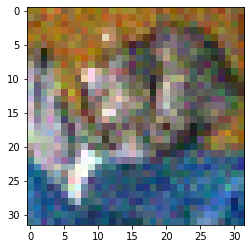

In [55]:
plt.imshow(tX[10000])

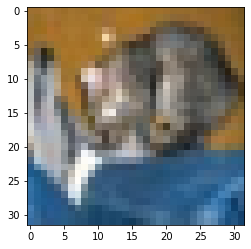

In [56]:
plt.imshow(tstX[0])

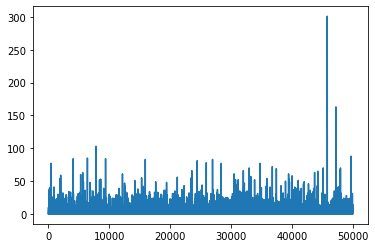

In [49]:
plt.plot(np.bincount(oodI[:, 0]))

# Distance

In [64]:
ds_name = "cifar100coarse"
preds, nnidxs, dists = joblib.load(f"nb_results/nowo-{ds_name.replace('coarse', '')}-c.pkl")
trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
_, ood_names = get_ood_data_paths(ds_name.replace('coarse', ''), "/tmp2")

In [65]:
def get_dist_pred_y(ds_name, model_name):
    ncg_dists = []
    ncg_preds = []
    ncgy = []
    rtsty = []

    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    
    key = (ds_name, model_name)
    for ood_name in ood_names:
        ncg_dists.append(dists[key][ood_name].reshape(-1))
        ncg_preds.append(preds[key][ood_name].argmax(1))
        ncgy.append(trny[nnidxs[key][ood_name].reshape(-1)])
        rtsty.append(np.tile(tsty, 5))

    ncg_dists = np.concatenate(ncg_dists)
    ncg_preds = np.concatenate(ncg_preds)
    ncgy = np.concatenate(ncgy)
    rtsty = np.concatenate(rtsty)
    return ncg_dists, ncg_preds, ncgy, rtsty

data = {}
for ds_name in ["cifar10", "cifar100coarse"]:
    preds, nnidxs, dists = joblib.load(f"nb_results/nowo-{ds_name.replace('coarse', '')}-c.pkl")
    print(dists.keys())
    for model_name in ["natural", "TRADES(2)", "AT(2)"]:
        ncg_dists, ncg_preds, ncgy, tsty = get_dist_pred_y(ds_name, model_name)
        data[(ds_name, model_name)] = (ncg_dists, ncg_preds, ncgy, tsty)

dict_keys([('cifar10', 'natural'), ('cifar10', 'TRADES(2)'), ('cifar10', 'AT(2)')])
dict_keys([('cifar100coarse', 'natural'), ('cifar100coarse', 'TRADES(2)'), ('cifar100coarse', 'AT(2)')])


In [66]:
bins = 5
offset = 0
model_name = "nat"

for ds_name in ["cifar10", "cifar100coarse"]:
    for offset, model_name in enumerate(["natural", "TRADES(2)", "AT(2)"]):
        ncg_dists, ncg_preds, ncgy, _ = data[(ds_name, model_name)]
        accs = (ncg_preds == ncgy)
        sort_idx = np.argsort(ncg_dists)

        xticks, xaxis, yaxis, yerrs = [], [], [], []
        for i in range(bins):
            idx = sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins]
            xticks.append("%.2f" % ncg_dists[idx].mean())
            xaxis.append(i + (offset-1)*0.2)
            yaxis.append(accs[idx].mean())
            yerrs.append(scipy.stats.sem(accs[idx]))
        plt.bar(xaxis, yaxis, yerr=yerrs, width=0.2, label=model_name)

    #plt.title(f"{ds_name}")
    plt.xticks(np.arange(bins), xticks, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("NCG score", fontsize=fontsize)
    plt.xlabel("Avg. $\ell_2$ dist. to the closest training example", fontsize=fontsize)
    #plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"figs/ncg_binned_dists/pixel-corrupted-all_{ds_name}.png", bbox_inches='tight')
    plt.close()
    
    
    for offset, model_name in enumerate(["natural", "TRADES(2)", "AT(2)"]):
        ncg_dists, ncg_preds, ncgy, all_tsty = data[(ds_name, model_name)]
        tstaccs = (ncg_preds == all_tsty)
        sort_idx = np.argsort(ncg_dists)

        xticks, xaxis, yaxis, yerrs = [], [], [], []
        for i in range(bins):
            idx = sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins]
            xticks.append("%.2f" % ncg_dists[idx].mean())
            xaxis.append(i + (offset-1)*0.2)
            yaxis.append(tstaccs[idx].mean())
            yerrs.append(scipy.stats.sem(tstaccs[idx]))
        plt.bar(xaxis, yaxis, yerr=yerrs, width=0.2, label=model_name)

    #plt.title(f"{ds_name}")
    plt.xticks(np.arange(bins), xticks, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("Test accuracy", fontsize=fontsize)
    plt.xlabel("Avg. $\ell_2$ dist. to the closest training example", fontsize=fontsize)
    #plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"figs/ncg_binned_dists/pixel-corrupted-all_tstacc_{ds_name}.png", bbox_inches='tight')
    plt.close()
    